# Development in Inflation and relation to development of Real rate

# introduction

Inflation is a measure of how prices develop in a country. In Denmark, there is a goal that inflation should not exceed 2 percent. When prices for goods and services rise, the purchasing power of consumers in a country decreases because their money becomes less valuable. In this project, we will investigate which categories drive the development of inflation. Interest rates and inflation are closely linked, as monetary policy uses interest rates to influence inflation. Therefore, an analysis will also be conducted, based on time series data, to determine whether interest rates affect inflation or vice versa.

Imports and set magics:

In [64]:
# Import and set magics
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.graph_objects as go


# Read and clean inflation data

First we read inflation data, and drop the last row, due to missing data.

In [65]:
#Read and print inflation data
df = pd.read_excel("Forbrugerprisindeks.xlsx")
print(df)

#Dropping last row due to missing data and print data
df = df.drop(df.index[-1])
print(df)

     Periode  00 Forbrugerprisindekset i alt  01.1 Fødevarer  \
0    2002M01                             2.5             3.7   
1    2002M02                             2.5             4.0   
2    2002M03                             2.6             3.4   
3    2002M04                             2.6             2.0   
4    2002M05                             2.0             1.7   
..       ...                             ...             ...   
262  2023M11                             0.6             2.9   
263  2023M12                             0.7             1.9   
264  2024M01                             1.2             1.7   
265  2024M02                             0.8            -0.9   
266      NaN                             0.9             NaN   

     01.2 Ikke-alkoholiske drikkevarer  02.1 Alkoholiske drikkevarer  \
0                                  1.5                          -1.7   
1                                  1.6                          -2.1   
2              

Now, we make a comprehensive cleaning of the data. This cleans and processes the 'Periode' column in a DataFrame that contains date information in formats like 'YYYY-QX' (e.g., '2021-Q3') or 'YYYYMM' (e.g., '202103'). The cleaning process standardizes the date information and ensures that the DataFrame can be used for time series analysis with a proper datetime index.

In [66]:
# Assuming 'Periode' column contains strings formatted like 'YYYY-QX' or 'YYYYMM'
# Try to extract Year and Quarter or Month
df['Year'] = df['Periode'].str.extract('(\d{4})')  # Extract the year

# Attempt to extract Quarter if present
df['Quarter'] = df['Periode'].str.extract('Q(\d)')

# Check if Quarter extraction was successful, otherwise assume it's a month
if df['Quarter'].isna().any():
    df['Month'] = df['Periode'].str.extract('(\d{2})$')  # Assuming format YYYYMM if no 'Q' present
else:
    # Handle the month as quarter to month conversion if needed
    df['Month'] = df['Quarter'].apply(lambda x: str(int(x) * 3 - 2).zfill(2))  # Convert quarter to starting month

# Combine Year and Month into a Period column and convert to datetime
df['Period'] = pd.to_datetime(df['Year'] + df['Month'], format='%Y%m')
df.set_index('Period', inplace=True)

# Show updated DataFrame
print("Updated DataFrame with datetime index:")
print(df)

# Saving the cleaned DataFrame for later use
df.to_excel("cleaned_Inflation.xlsx")

Updated DataFrame with datetime index:
            Periode  00 Forbrugerprisindekset i alt  01.1 Fødevarer  \
Period                                                                
2002-01-01  2002M01                             2.5             3.7   
2002-02-01  2002M02                             2.5             4.0   
2002-03-01  2002M03                             2.6             3.4   
2002-04-01  2002M04                             2.6             2.0   
2002-05-01  2002M05                             2.0             1.7   
...             ...                             ...             ...   
2023-10-01  2023M10                             0.1             3.5   
2023-11-01  2023M11                             0.6             2.9   
2023-12-01  2023M12                             0.7             1.9   
2024-01-01  2024M01                             1.2             1.7   
2024-02-01  2024M02                             0.8            -0.9   

            01.2 Ikke-alkoholiske dri

# Plot of inflation

Now we make a plot, for making an analysis of time series for inflation. 

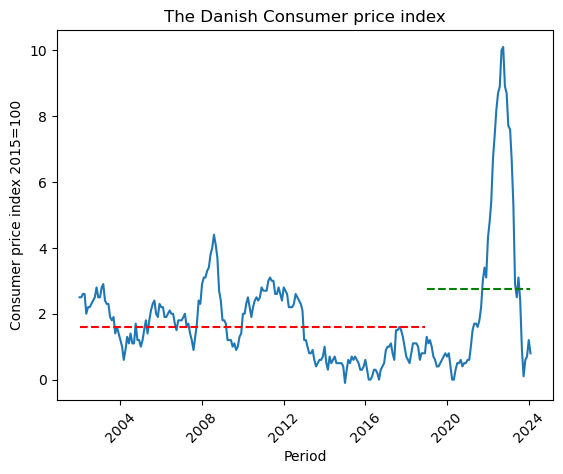

In [67]:
# Plotting the values of the column 00 Forbrugerprisindekset i alt (meaning priceindex in total)
Consumerpriceindex = df['00 Forbrugerprisindekset i alt']
plt.plot(df.index, Consumerpriceindex)

#dividing into two periods
first_period = df[(df.index.year >= 2002) & (df.index.year <= 2018)]
second_period = df[(df.index.year >= 2019) & (df.index.year <= 2024)]

#Finding mean for each period
mean_first_period = first_period['00 Forbrugerprisindekset i alt'].mean()
mean_second_period = second_period['00 Forbrugerprisindekset i alt'].mean()

# Plot mean trend lines for each period
plt.hlines(mean_first_period, first_period.index.min(), first_period.index.max(), colors='r', linestyles='--', label=f'Mean 2002-2018: {mean_first_period:.2f}')
plt.hlines(mean_second_period, second_period.index.min(), second_period.index.max(), colors='g', linestyles='--', label=f'Mean 2018-2024: {mean_second_period:.2f}')
plt.title('The Danish Consumer price index') 
plt.xlabel('Period')
plt.ylabel('Consumer price index 2015=100')
plt.xticks(rotation=45)
plt.show()


The plot above shows the time series for the Danish Consumer Price Index (CPI), with 2015 as the base year. The time series exhibits several fluctuations throughout the period.

2002 to 2007: Initially, the CPI fluctuates around 2, aligning with the target for the Danish economy.

2008: There is a notable spike in the CPI, likely due to the global financial crisis.

2022: Another significant spike occurs, which can be attributed to recent global economic events, such as the COVID-19 pandemic and supply chain disruptions.

Analyzing the trends:

2002 to 2019: The CPI demonstrates a relatively stable trend with moderate growth, maintaining a lower mean level.

2020 to 2024: The mean CPI increases, as indicated by the green line, reflecting a higher level compared to the earlier period. This rise is primarily due to the substantial spike around 2022.

Overall, the recent period (2020-2024) shows higher volatility and increased inflation levels, contrasting with the more stable trend observed in the earlier years. This indicates that while there are periods of economic stability, recent global events have introduced significant volatility and higher inflation levels in the Danish economy.

# Analysis - what drives inflation

For making a deeper analysis, we delve into what drives the inflation. This is done, by looking at the biggest and most volatile sectors. Here Foods, Electricity, Gas and Other fuel and Rent is choosen.

In [68]:
# creating figure
fig = go.Figure()

# Adding the data for each sector
fig.add_trace(go.Scatter(x=df.index, y=df['01.1 Fødevarer'], mode='lines', name='Food'))
fig.add_trace(go.Scatter(x=df.index, y=df['04.5 Elektricitet, gas og andet brændsel'], mode='lines', name='Electricity, Gas and Other Fuel'))
fig.add_trace(go.Scatter(x=df.index, y=df['04.1 Faktisk husleje'], mode='lines', name='Actual Rent'))
fig.add_trace(go.Scatter(x=df.index, y=df['00 Forbrugerprisindekset i alt'], mode='lines', name='Overall CPI'))

# Extracting unique years from the index
years = df.index.year.unique()

# Adding plot title and labels
fig.update_layout(
    title='Development in Danish Consumer Price Index for Selected Categories',
    xaxis_title='Period',
    yaxis_title='Index Value (2015=100)',
    legend_title='Categories',
    xaxis=dict(
        tickmode='array',
        tickvals=[pd.Timestamp(str(year)) for year in years],
        ticktext=[str(year) for year in years]
    )
)

# Rotating x-axis labels
fig.update_xaxes(tickangle=90)

fig.show()


The interactive figure illustrates the development of the Danish Consumer Price Index (CPI) for selected categories: Food, Electricity, Gas and Other Fuel, Actual Rent, and the overall CPI. The base year is set to 2015 (index value = 100). Given the large fluctuations in energy prices, the interactive plot allows users to remove "Electricity, Gas and Other Fuel" by clicking on the category label on the right. This adjustment changes the y-axis scale, providing a clearer view of the fluctuations in categories like actual rent.

From the start of the period until 2021, the fluctuations remain fairly stable. However, from 2021 onwards, there is a noticeable spike in inflation related to food products, which significantly impacts the overall CPI.

Energy prices exhibit greater volatility throughout the entire period, with several notable spikes. The largest spike occurs around 2021, indicating a substantial increase in prices followed by a sharp decline.

Rent prices show minimal fluctuations, making it useful to utilize the interactive feature to remove "Electricity, Gas and Other Fuel" from the figure. This adjustment provides a better view of the subtle fluctuations in actual rent, though they remain relatively low compared to other categories.

Overall, the chosen categories demonstrate significant fluctuations, which are key drivers of inflation development. The data shows that actual rent is the most stable category, whereas energy prices exhibit the highest volatility. The overall CPI is heavily influenced by the volatility in food and energy prices, leading to a significant increase and subsequent decline post-2020. The stability in rent prices helps stabilize the overall CPI but is overshadowed by the fluctuations in food and energy prices.

The fluctuations observed in the later period (2020-2023) can be attributed to the COVID-19 crisis. The pandemic caused disruptions in the supply chain, contributing to increased food prices. Additionally, geopolitical tensions have partly explained the fluctuations in the energy sector and the corresponding price changes.


# Further analysis - is there a comparison between real rate and inflation

For furhter analysis, an investegation on the relationship between real rate and inflation is made. Firstly data for the "National Bank Interest Rate - Folio Deposits" is loaded and cleaned. As it is daily data and we want to analyze it on a monthly basis.

Import real rate and cleaning

In [69]:
# Load the Real rate data
Rate_data = pd.read_excel('Rente data.xlsx')
print(Rate_data)

# Convert the DATE column to datetime format for easier manipulation
Rate_data['DATE'] = pd.to_datetime(Rate_data['DATE'], format='%YM%mD%d')

# Set the DATE column as the index
Rate_data.set_index('DATE', inplace=True)

# Resample the data to monthly frequency and calculate the mean for each month
monthly_data = Rate_data.resample('M').mean()

# Format the date to 'YYYYMM' format with 'M' in the middle
monthly_data.index = monthly_data.index.strftime('%Y') + 'M' + monthly_data.index.strftime('%m')

# Rename the index to 'DATE' to reflect the original format
monthly_data.index.name = 'DATE'

# Display the final dataframe
print(monthly_data)

# Optionally, save the dataframe to a new Excel file
monthly_data.to_excel('Monthly_Real_Rate.xlsx')

# Display the first few rows of the formatted monthly data
print(monthly_data.head())

# Save as cleaned real rate data
monthly_data.to_excel("cleaned_Realrate.xlsx")



            DATE  OBS.VALUE
0     2004M09D01        2.0
1     2004M09D02        2.0
2     2004M09D03        2.0
3     2004M09D06        2.0
4     2004M09D07        2.0
...          ...        ...
4916  2024M04D24        3.6
4917  2024M04D25        3.6
4918  2024M04D26        3.6
4919  2024M04D29        3.6
4920  2024M04D30        3.6

[4921 rows x 2 columns]
         OBS.VALUE
DATE              
2004M09        2.0
2004M10        2.0
2004M11        2.0
2004M12        2.0
2005M01        2.0
...            ...
2023M12        3.6
2024M01        3.6
2024M02        3.6
2024M03        3.6
2024M04        3.6

[236 rows x 1 columns]
         OBS.VALUE
DATE              
2004M09        2.0
2004M10        2.0
2004M11        2.0
2004M12        2.0
2005M01        2.0


Final cleaning of data for inflation and real rate, so the datasets are mergeable. this include some formatting and dropping of values, so the time periods are the same.

In [70]:
import pandas as pd

# Import cleaned Inflation Data
df_inflation = pd.read_excel("cleaned_Inflation.xlsx")

#further cleaing for inflation Data
# Renaming 'Periode' to 'DATE'
df_inflation.rename(columns={'Periode': 'DATE'}, inplace=True)

# Dropping all columns except '00 Forbrugerprisindekset i alt'
df_inflation = df_inflation[['DATE', '00 Forbrugerprisindekset i alt']]

# Converting 'DATE' to datetime format assuming the format is YYYYMM
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'], format='%YM%m')

# Dropping rows before '2004-09-01'
df_inflation = df_inflation[df_inflation['DATE'] >= '2004-09-01']

# Import Real rate data
df_realrate = pd.read_excel("cleaned_Realrate.xlsx")

# Convert 'DATE' to datetime format assuming the format is YYYYMM
df_realrate['DATE'] = pd.to_datetime(df_realrate['DATE'], format='%YM%m')

# Merge the two dataframes on the 'DATE' column
merged_df = pd.merge(df_inflation, df_realrate, on='DATE')

# Rename the relevant columns to 'inflation' and 'real_rate'
merged_df.rename(columns={
    '00 Forbrugerprisindekset i alt': 'inflation',
    'OBS.VALUE': 'real_rate'
}, inplace=True)

print(merged_df)

# Optionally, save the merged data to a new Excel file
merged_df.to_excel('merged_data.xlsx', index=False)

          DATE  inflation  real_rate
0   2004-09-01        1.1        2.0
1   2004-10-01        1.7        2.0
2   2004-11-01        1.2        2.0
3   2004-12-01        1.2        2.0
4   2005-01-01        1.0        2.0
..         ...        ...        ...
229 2023-10-01        0.1        3.6
230 2023-11-01        0.6        3.6
231 2023-12-01        0.7        3.6
232 2024-01-01        1.2        3.6
233 2024-02-01        0.8        3.6

[234 rows x 3 columns]


Making a plot of the merge dataset.

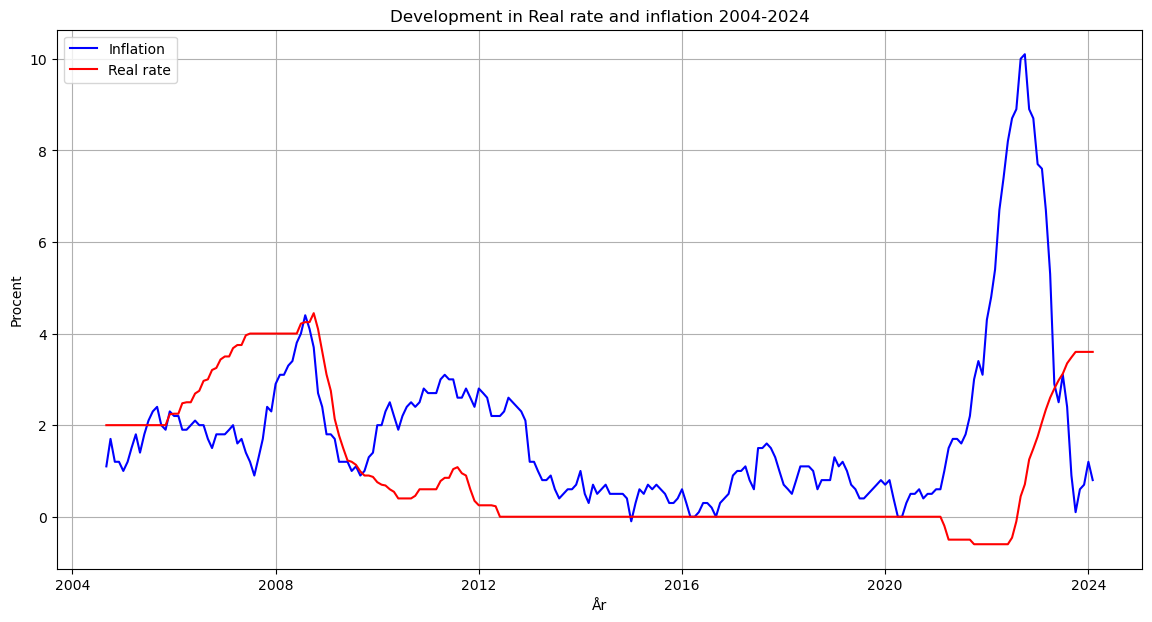

In [71]:
# Reading merged data file.
data = pd.read_excel('merged_data.xlsx')

# Plotting real rate and inflation
plt.figure(figsize=(14, 7))
plt.plot(data['DATE'], data['inflation'], label='Inflation', color='blue')
plt.plot(data['DATE'], data['real_rate'], label='Real rate', color='red')
plt.xlabel('År')
plt.ylabel('Procent')
plt.title('Development in Real rate and inflation 2004-2024')
plt.legend()
plt.grid(True)
plt.show()


The figure above shows the time series for the real rate and inflation over time. There is a clear tendency for their fluctuations to align, indicating that when inflation rises, the real rate often increases as well, and vice versa. From 2013 until 2021, the real rate remained steady at zero, reflecting a period of stability and the absence of negative real rates. However, starting in 2021, negative real rates emerged. During the same period, a significant spike in inflation was observed, followed by a corresponding rise in the real rate. This pattern highlights the typical response of real rates to changes in inflation, as central banks adjust interest rates to manage economic conditions.

For making a more comprehensive analysis, of whether it is the inflation that drives real rate, or vice versa, making a granger causality test is the most efficient way. So, we make a granger test for both inflation to real rate and vice versa. Afterwards, we plot them together with the signifance level of 0.05. For one of them to drive the other, most of the lags has to be signifanct. 

**Granger Causality Test Steps:**
1. **Hypothesis Testing**:
   - Null Hypothesis (H0): Lagged values of one variable do not explain the other variable.
   - Alternative Hypothesis (H1): Lagged values of one variable do explain the other variable.
2. **Direction of Causality**:
   - Test whether inflation Granger-causes real interest rates.
   - Test whether real interest rates Granger-cause inflation.
3. **Significance Level**: Typically set at 0.05. If the p-value is less than 0.05, we reject the null hypothesis.

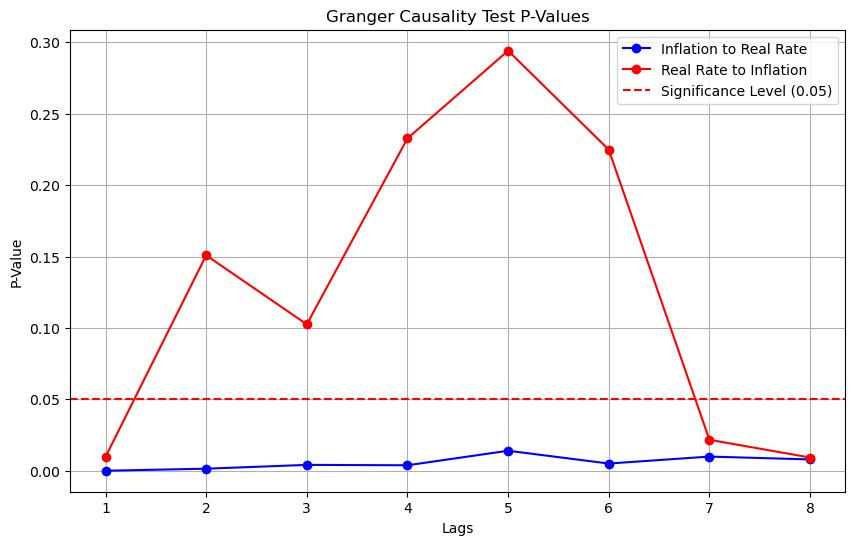

In [73]:
# Perform Granger causality test for both directions
max_lag = 8

# Granger causality tests
granger_test_inflation_to_real_rate = grangercausalitytests(merged_df[['real_rate', 'inflation']].dropna(), max_lag, verbose=False)
granger_test_real_rate_to_inflation = grangercausalitytests(merged_df[['inflation', 'real_rate']].dropna(), max_lag, verbose=False)

# Function to extract p-values from Granger causality test results
def extract_pvalues(results, max_lag):
    return [results[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]

# Extract p-values for both directions
p_values_inflation_to_real_rate = extract_pvalues(granger_test_inflation_to_real_rate, max_lag)
p_values_real_rate_to_inflation = extract_pvalues(granger_test_real_rate_to_inflation, max_lag)

# Plot the p-values for both directions
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_lag + 1), p_values_inflation_to_real_rate, marker='o', label='Inflation to Real Rate', color='blue')
plt.plot(range(1, max_lag + 1), p_values_real_rate_to_inflation, marker='o', label='Real Rate to Inflation', color='red')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.title('Granger Causality Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.legend()
plt.grid(True)
plt.show()


The plot above shows the p-values for our Granger causality tests compared to the significance level of 0.05. The red line represents the test where the real rate Granger-causes inflation, and the blue line represents the test where inflation Granger-causes the real rate. It is clear that the inflation significantly influences the real rate at all lags, as the blue line's p-values are consistently below the 0.05 significance level. On the other hand, the red line's p-values are mostly above the significance level, indicating that the real rate does not significantly Granger-cause inflation.

This can be effectively interpreted as inflation levels driving real rate levels. When inflation rises, the real rate tends to increase as well, and vice versa. This aligns with economic intuition, where central banks adjust the real interest rate to manage inflation through monetary policy. When inflation is too high, central banks raise the real rate to cool down the economy and reduce inflation, known as contractionary monetary policy. Conversely, when inflation is too low, central banks may lower the real rate to stimulate economic activity, known as expansionary monetary policy.

The observed relationship is consistent with our analysis and reflects typical central bank behavior in response to inflationary pressures. The Granger causality tests confirm that inflation has a leading role in determining real rate adjustments.

# Conclusion

This project was made, to investeage what drives the inflation for the past 20 years. Furthermore, an investegation on the relationship between real rate and inflation was made. 

Using data from Danmark Statistik on "National Bank Interest Rate - Folio Deposits" and "Consumer price index" we started by cleaning and organizing data, so plotting, merging and other analysis would become straight forward.

Firstly, inflation fluctuated a lot in the period. Especially driven by the energy prices and food. Rent on the other hand held the inflation to be more stable. 